In [1]:
import pandas as pd
import numpy as np
import re
import itertools
import statistics as stats
import scipy.stats
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.ticker as mtick
import statsmodels.api as sm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 1000)
pd.set_option("display.colheader_justify","left")
sns.set()

In [2]:
#TODO: [['is_open']==1] #10,000 ---> 7,000

#pd.options.display.max_colwidth = 10000

businesses = pd.read_csv("restaurants.csv", index_col=0)
restaurants = businesses[(businesses['categories'].str.contains('food',case=False)|
                          businesses['categories'].str.contains('restaurant',case=False))
                         &
                         (businesses['categories'].str.contains('indian',case=False)|
                          businesses['categories'].str.contains('thai',case=False)|
                          businesses['categories'].str.contains('chinese',case=False)|
                          businesses['categories'].str.contains('japanese',case=False)|
                          businesses['categories'].str.contains('mex',case=False)|
                          businesses['categories'].str.contains('french',case=False)|
                          businesses['categories'].str.contains('italian',case=False)|
                          businesses['categories'].str.contains('vegan',case=False)|
                          businesses['categories'].str.contains('vietnamese',case=False)|
                          businesses['categories'].str.contains('american',case=False))]
restaurants.drop(['postal_code', 'latitude','longitude', 'attributes','hours'], axis=1, inplace=True)
restaurant_reviews = pd.read_csv('restaurants_reviews.csv', index_col='business_id')
restaurant_reviews = restaurant_reviews[restaurant_reviews.index.isin(restaurants.index)]
print(f'restaurants: {len(restaurants)} \n {restaurants.columns} ')
print(f'restaurant_reviews: {len(restaurant_reviews)} \n {restaurant_reviews.columns} ')
restaurant_reviews.columns.values[2]='stars_reviews' #rename so there is no more than 1 column named "stars"
df = restaurant_reviews.join(restaurants, how='left')
df.drop(['user_id', 'useful', 'funny', 'cool', 'address', 'date'],axis=1, inplace=True)
df.dropna(axis=0,inplace=True)
df.is_open = df.is_open.astype(bool)

/Users/danny/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


restaurants: 33709 
 Index(['name', 'address', 'city', 'state', 'stars', 'review_count', 'is_open',
       'categories'],
      dtype='object') 
restaurant_reviews: 3432459 
 Index(['review_id', 'user_id', 'stars', 'useful', 'funny', 'cool', 'text',
       'date'],
      dtype='object') 


In [3]:
#Count the number of dirty words in a review
dirty_regex = '(dirty)|(unclean)|(not sanitary)|(not clean)|(unsanitary)|(filthy)'
dirty_words_count = []
for i in df['text']:
    temp = ["".join(x) for x in re.findall(dirty_regex, i,flags=re.IGNORECASE)]
    dirty_words_count.append(len(temp)) 
df['dirty_words_count'] = dirty_words_count

clean_regex = '(clean)|(sanitary)|(tidy)|(neat)|(spotless)|(pristine)'
dirty_words_count = []
for i in df['text']:
    temp = ["".join(x) for x in re.findall(dirty_regex, i,flags=re.IGNORECASE)]
    dirty_words_count.append(len(temp)) 
df['dirty_words_count'] = dirty_words_count

#Assign other variables for reviews 
df['dirty'] = df['dirty_words_count']>0 #review has dirty? True/False
df['grouped_review_count'] = df['text'].groupby(level=0).count() #number of reviews by business index
df['business_dirty_total'] = df['dirty'].groupby(level=0).sum().astype('int32') #total number of dirty reviews for business

##STILL NOT USED for visualization

In [4]:
#restaurant only DataFrame, no reviews
restaurant_info = df.drop(['review_id', 'stars_reviews','text','dirty', 'dirty_words_count'],
                          axis=1).drop_duplicates() #drop review-related variables

restaurant_info['has_dirty_reviews'] = restaurant_info['business_dirty_total']>0 #business has dirty reviews T/F
restaurant_info['dirty_ratio'] = restaurant_info['business_dirty_total']/restaurant_info['grouped_review_count'] 
restaurant_info['stars_reviews'] = df.groupby(by='business_id').mean()['stars_reviews']

#^ number of dirty reviews / total review count for business

#Setting cuisine column
cuisine_regex = '(chinese)|(thai)|(japanese)|(italian)|(french)|(american)|(vegan)|(indian)|(mex)|(vietnamese)'
appended_cuisines = []
for i in restaurant_info['categories']:
    temp = ["".join(x) for x in re.findall(cuisine_regex, i,flags=re.IGNORECASE)]
    appended_cuisines.append(','.join(dict.fromkeys(temp))) 
restaurant_info['cuisine'] = appended_cuisines
restaurant_info.drop(restaurant_info[restaurant_info['cuisine'].str.contains(',')].index, inplace=True) #drop any restaurants with a duplicate cuisine catgory
restaurant_info.cuisine.where(~(restaurant_info['cuisine']=='Mex'), 'Mexican', inplace=True) #Fix Mexican category
restaurant_info.drop(restaurant_info[restaurant_info['categories'].str.contains('Latin American', case=False)].index, inplace=True)
#restaurant_info.columns = ['name', 'city', 'state', 'stars', 'review_count', 'is_open',
       'categories', 'Number of Reviews', 'business_dirty_total',
       'has_dirty_reviews', 'dirty_ratio','stars_reviews', 'cuisine']
restaurant_info.drop(restaurant_info[restaurant_info.dirty_ratio>.3].index, inplace=True) #dropping very dirty outliers

#NUMBER OF REVIEWS FILTER:

minimum_reviews = 50
maximum_reviews = 5000    #get's rid of some outliers
restaurant_info = restaurant_info[restaurant_info['Number of Reviews']>minimum_reviews]
restaurant_info = restaurant_info[restaurant_info['Number of Reviews']<maximum_reviews]


#GROUPBY DATAFRAMES

restaurant_info_groupby_mean = restaurant_info.groupby('cuisine').mean()
restaurant_info_groupby_mean['cuisine'] = restaurant_info_groupby_mean.index

IndentationError: unexpected indent (<ipython-input-4-57130d24be03>, line 22)


To sum up what I've done so far: 
* I took review data and joined it with data for the business that corresponds with it. Currently only looking at restaurants/food establishments that belong to 10 cuisines. Dropped any rows with duplicates cuisines (i.e. American AND Chinese). 
* I've defined a review as being "dirty" if it contains any of the following words:
    * unclean / not clean
    * unsanitary / not sanitary
    * dirty
    * filthy   

* Defined a few varibles:
    * has_dirty_reviews - True/False for whether the business has had a dirty review before
    * dirty_ratio - # of "dirty" reviews per business / TOTAL Reviews per business
    * grouped_review_count - this is the # of reviews per business because Yelp data provided did not count it properly 

In [ ]:
restaurant_info['cuisine'].value_counts()

In [ ]:
restaurant_info.corr()
cmap = sns.diverging_palette(220,10,as_cmap=True)
ax = sns.heatmap(df.drop('text',axis=1).corr(), annot=True, cmap=cmap)


In [7]:
restaurant_info

,name,city,state,stars,review_count,is_open,categories,Number of Reviews,business_dirty_total,has_dirty_reviews,dirty_ratio,stars_reviews,cuisine
business_id,,,,,,,,,,,,,
--6MefnULPED_I942VcFNA,John's Chinese BBQ Restaurant,Richmond Hill,ON,3.0,55,True,"Chinese, Restaurants",57,0,False,0.000000,2.877193,Chinese
--FBCX-N37CMYDfs790Bnw,The Bar At Bermuda & St. Rose,Henderson,NV,4.0,166,True,"American (New), Nightlife, Beer, Wine & Spirits, Restaurants, Food, Bars",174,1,True,0.005747,3.862069,American
--I7YYLada0tSLkORTHb5Q,Happy Moose Bar and Grill,Streetsboro,OH,3.5,116,True,"Bars, Nightlife, Restaurants, Sports Bars, American (Traditional)",120,3,True,0.025000,3.416667,American
--S62v0QgkqQaVUhFnNHrw,Denny's,Highland Heights,OH,2.0,56,True,"American (Traditional), Breakfast & Brunch, Diners, Restaurants",57,6,True,0.105263,2.052632,American
--ujyvoQlwVoBgMYtADiLA,Primanti Bros,Pittsburgh,PA,3.5,84,True,"Restaurants, Sandwiches, Sports Bars, American (New), Nightlife, Bars",90,1,True,0.011111,3.622222,American
...,...,...,...,...,...,...,...,...,...,...,...,...,...
zydbdBR6-CM8UZ6WkW1DWA,Marie's Restaurant,Wadsworth,OH,3.0,72,True,"Pizza, Italian, Chicken Wings, Restaurants",76,4,True,0.052632,2.921053,Italian
zzSYBWuv_fXGtSgsO-6_1g,Bowl Of Pho,Woodmere,OH,4.0,225,True,"Vietnamese, Specialty Food, Ethnic Food, Restaurants, Food, Soup, Vegetarian",230,1,True,0.004348,3.847826,Vietnamese
zzmIMvqiBJ_-wVKg_OnGpw,Gianni's Trattoria,Concord,NC,4.0,139,True,"Restaurants, Italian, Food",141,1,True,0.007092,4.106383,Italian


[Text(0, 0.5, 'Mean Review Rating'),
 Text(0.5, 0, 'Mean Dirty Review Percentage'),
 Text(0.5, 1.0, 'Dirty Review Percentage, Review Rating, and Number of Reviews Averaged over Cuisine Category')]

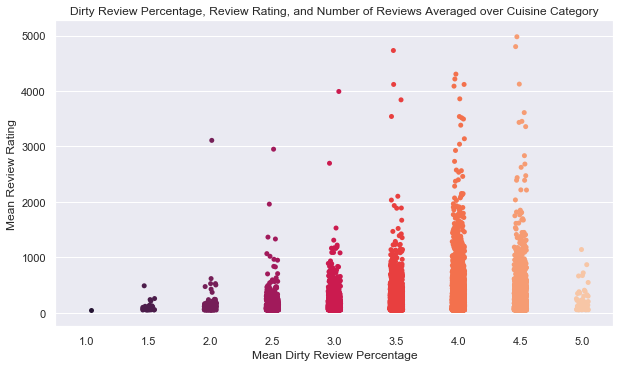

In [39]:
(fig99, ax99) = plt.subplots(figsize=(10,5.625))
sns.stripplot(x='stars',y='Number of Reviews', data=restaurant_info, palette= 'rocket')
ax99.set(ylabel = 'Number of Ratings', xlabel='Mean Dirty Review Percentage', title = 'Dirty Review Percentage, Review Rating, and Number of Reviews Averaged over Cuisine Category')

#plt.ylim(0,2000)

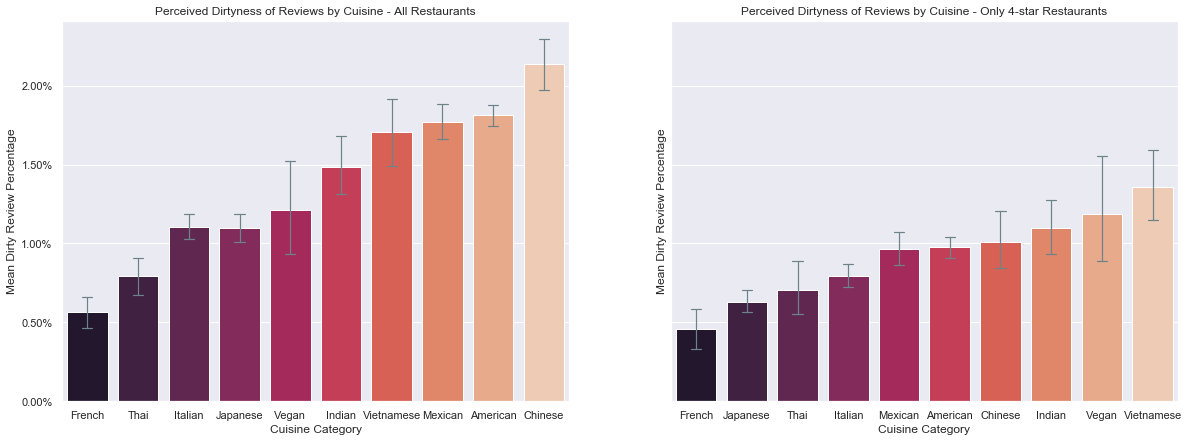

In [40]:
fig, (ax1, ax4) = plt.subplots(ncols=2, sharey=True, figsize=(20,7))

ax1 = sns.barplot(x='cuisine',y='dirty_ratio', data=restaurant_info, capsize=.2, errwidth=1.2, 
                  order=['French', 'Thai', 'Italian','Japanese', 'Vegan', 'Indian',
       'Vietnamese', 'Mexican', 'American', 'Chinese'], palette="rocket", errcolor='#6D838C', ax=ax1)
ax1.set(xlabel = 'Cuisine Category', ylabel="Mean Dirty Review Percentage", title = 'Perceived Dirtyness of Reviews by Cuisine - All Restaurants')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax4 = sns.barplot(x='cuisine',y='dirty_ratio', data=restaurant_info[restaurant_info.stars==4], capsize=.2, errwidth=1.2, 
                  order=['French', 'Japanese', 'Thai', 'Italian', 'Mexican', 'American',
       'Chinese', 'Indian', 'Vegan', 'Vietnamese'], palette="rocket", errcolor='#6D838C', ax=ax4)
ax4.set(xlabel = 'Cuisine Category', ylabel="Mean Dirty Review Percentage", title = 'Perceived Dirtyness of Reviews by Cuisine - Only 4-star Restaurants')
ax4.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

#### x-axis: Cuisine Category

#### y-axis: Percentage of a restaurant's reviews with negative hygienic feedback, averaged over each cuisine category

Chinese restaurants are viewed by yelp reviewers as the dirtiest, along with American and Mexican Restaurants. In contrast, French restaurants are by far viewed as the cleanest, followed by Thai and Japanese.

(0, 0.03)

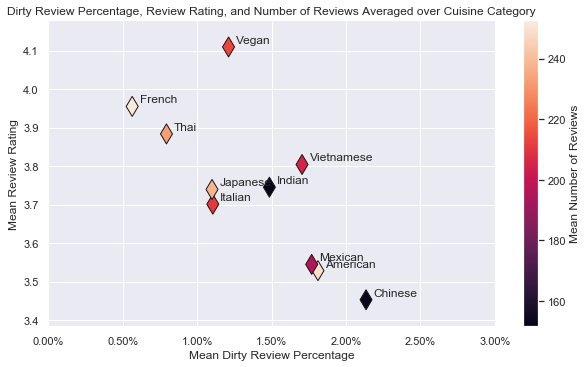

In [29]:
restaurant_info_groupby_mean.columns = ['stars', 'review_count', 'is_open', 'Mean Number of Reviews',
       'business_dirty_total', 'has_dirty_reviews', 'dirty_ratio',
       'stars_reviews', 'cuisine']

(fig2, ax2) = plt.subplots(figsize=(10,5.625))
ax2 = restaurant_info_groupby_mean.plot(x = 'dirty_ratio', y = 'stars_reviews', kind='scatter', colormap="rocket",
                       c='Mean Number of Reviews', s = 200, edgecolor='#201613', marker='d', ax=ax2)


for i, txt in enumerate(restaurant_info_groupby_mean.index):
     ax2.annotate(txt, (restaurant_info_groupby_mean['dirty_ratio'][i]+.0005,restaurant_info_groupby_mean['stars_reviews'][i]+.01))

ax2.set(ylabel = 'Mean Review Rating', xlabel='Mean Dirty Review Percentage', title = 'Dirty Review Percentage, Review Rating, and Number of Reviews Averaged over Cuisine Category')
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlim(0,.03)
#plt.ylim(3.4,4.2);

#### x-axis: Percentage of a restaurant's reviews with negative hygienic feedback, averaged over each cuisine category

#### y-axis: Average Review Rating (non-discretized)

#### Colormap: Average Number of Reviews per business

To supplement the bar chart above, this scatter plot shows the same data with the average number of reviews per business, as well as the average business rating on yelp 

A few inferences can be made: 

* restaurants with fewer reviews (such as chinese and indian) are perceived as less hygienic, with the exception of american restaurants. Inversely, french restaurants are perceived as the cleanest and have some of the highest review counts on average 
* there is a clear correlation between perceived restaurant hygiene and review rating. 

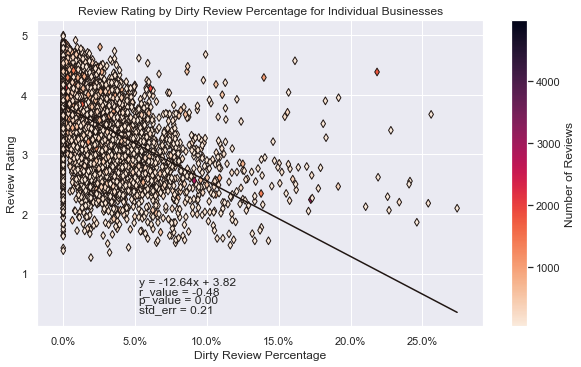

In [16]:
restaurant_info.columns = ['name', 'city', 'state', 'stars', 'review_count', 'is_open',
       'categories', 'Number of Reviews', 'business_dirty_total',
       'has_dirty_reviews', 'dirty_ratio', 'stars_reviews', 'cuisine']

(fig3, ax3) = plt.subplots(figsize=(10,5.625))
ax3 = restaurant_info.plot(x = 'dirty_ratio', y = 'stars_reviews', kind='scatter', colormap="rocket_r",
                       c='Number of Reviews', s = 30, edgecolor='#201613', marker='d', ax=ax3)
ax3.set(ylabel = 'Review Rating', xlabel='Dirty Review Percentage', title = 'Review Rating by Dirty Review Percentage for Individual Businesses')
ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1))
#plt.xlim(0,1)
#plt.ylim(0,5)

x=restaurant_info.dirty_ratio
y= restaurant_info.stars_reviews
gradient, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
line = gradient*x+intercept
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x1,y1,color='#201613', label='y={:.2f}x+{:.2f}'.format(gradient,intercept))

ax3.annotate('y = {:.2f}x + {:.2f}'.format(gradient,intercept), (.053,.80))
ax3.annotate('r_value = {:.2f}'.format(r_value), (.053,.65))
ax3.annotate('p_value = {:.2f}'.format(p_value), (.053,.50))
ax3.annotate('std_err = {:.2f}'.format(std_err), (.053,.35));


#### x-axis: Percentage of restaurant's reviews with negative hygienic feedback

#### y-axis: Review Rating for Business

#### Colormap: Number of Reviews for Business

By analyzing a scatterplot of all of the business in the dataset, we can create a linear regression between the dirty review percentage and the review rating. With an R-value of -.5, there is a moderate inverse relationship between the the percent of dirty reviews and the review rating